In [1]:
import matplotlib.pyplot as plt
#pylap inline
import sympy as sym
import numpy as np
from time import time as tm
from scipy.sparse.linalg import spsolve

import FDMethods as fdmet
import FDMethodsSparseMatrix as spafdmet

Point 1

Use the FD to evaluate the derivative of $f(x)=\frac{x^2}{2}$. Compare the speed of code for sparse matrix and starndard implementation at length of nodes in grid.

In [3]:
# Define the problem
t = sym.var('t')
fsym = 0.5 * t**2
f = sym.lambdify(t, fsym )
# Define the domain: omega
a=0
b=1


# The grid will be composed by 10 nodes to 1000 nodes
times = np.zeros(9, dtype=np.float32)
times_sp = np.zeros(9, dtype=np.float32)


for idx, N in enumerate(range(1000,10000, 1000)):
    
    x = np.linspace(a,b,N+1)

    
    method = fdmet.first_order_first_derivative_FiniteDiff(N,(b-a)/N)
    start_time = tm()
    matrix_fd = method.FD()
    uh = matrix_fd.dot(f(x))[1:N]
    stop_time = tm()
    times[idx] = stop_time-start_time

    del start_time
    del stop_time



    
    method_sp = spafdmet.first_order_first_derivative_FiniteDiff_sparse_method(N,(b-a)/N)
    start_time_sp = tm()
    matrix_sp_fd = method_sp.FD()
    uh = matrix_sp_fd.dot(f(x))[1:N]
    stop_time_sp = tm()
    times_sp[idx] = stop_time_sp-start_time_sp

    del start_time_sp
    del stop_time_sp

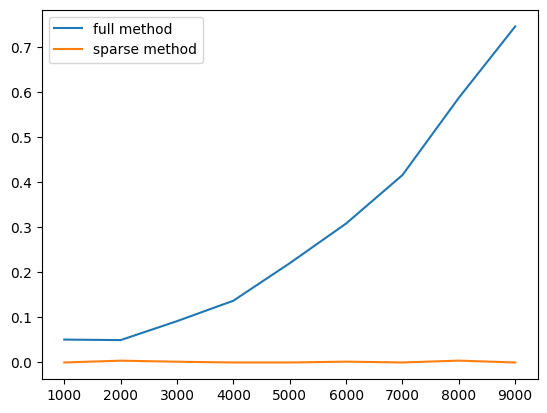

In [4]:
plt.plot(np.array(range(1000,10000, 1000)), times, label="full method")
plt.plot(np.array(range(1000,10000, 1000)), times_sp, label="sparse method")
plt.legend()
plt.show()

It is possible to see that the sparse matrix is much faster that full method

Point 2

Poisson problem in 1D:

$-u''(x)=f(x) \quad \in (a,b)$

$u(a)=0, \quad u(b)=\pi$

We use the second central divided difference to approximate the second derivative.

Given $h>0$,

$u''(x)≈\frac{u(x+h)-2u(x)+u(x-h)}{h^2}$


Test for $u(x)=sin(x)$


Define FD problem:

for $h=(b-a)/N$

$ A U = - h^2 F $

with $A$ the nominator of CD formula

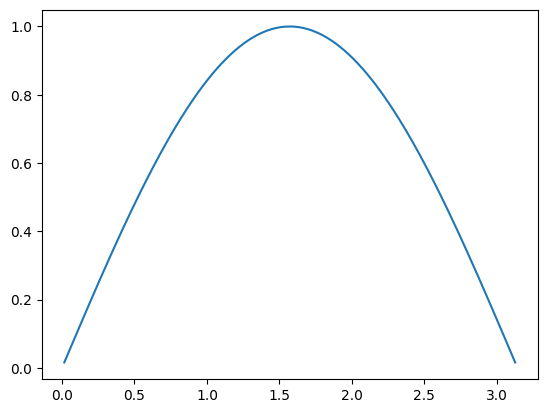

In [5]:
# Problem domain
a=0
b=np.pi

# Size of grid
N=200
# step size
h=(b-a)/N

# Define right-hand side function
t = sym.var('t')
fsym = sym.sin(t)
f = sym.lambdify(t, fsym )

# Define exact solution (since we are testing with sin(x))
usym = sym.sin(t)
u = sym.lambdify(t, fsym )

# Grid
x=np.linspace(a,b,N+1)

# A matrix
matrix_diff_method = spafdmet.second_derivative_FiniteDiff_sparse_method(N)
matrix = matrix_diff_method.CD()

# Right-hand side
F = -h**2*f(x[1:-1])

# Homogeneous Dirichlet boundary conditions
A_matrix = matrix[1:-1,1:-1]


# Compute solution at internal nodes
uh = spsolve(A_matrix,F)
# plot solution
plt.plot(x[1:-1],uh)
plt.show()


Test the order of convergence of CD for second derivative: expected order 2.

In [11]:

no_expe = 10
error = np.zeros(no_expe)
NN = np.zeros(no_expe)

for i in range(no_expe):
    #Setup grid and parameters
    N = 2**(i+1)
    NN[i] = N
    x = np.linspace(a,b,N+1)
    h = (b-a)/N
    
    #Compute the matrix for the simulation
    matrix_diff_method = spafdmet.second_derivative_FiniteDiff_sparse_method(N)
    A = matrix_diff_method.CD()
    A = A[1:-1,1:-1]
    
    #Compute the forcing term and perform the simulation
    F=-h**2*f(x[1:-1])
    uh = spsolve(A,F)
    
    #Compute error
    error[i] = max(abs(uh-u(x[1:-1])))

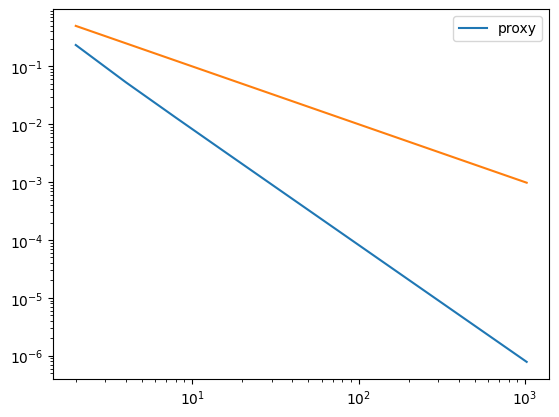

In [12]:
plt.loglog(NN,error, label = "proxy")
plt.loglog(NN,NN**(-1))
plt.legend()
plt.show()

Computing the slope of blue line it appears that is 2. Order of convergence respected.

Point 3

Solve the problem with nonhomogeneous Dirichlet conditions:

$-\alpha u''(x)=f(x) \quad \in (a,b)$



Fixing: $(a,b)=(0,\pi/2)$, $u(x) = sin(x)$ , $\alpha=\frac{1}{2}$


$u(a)=0, \quad u(b)=1$

$f = -\alpha sin(x)$


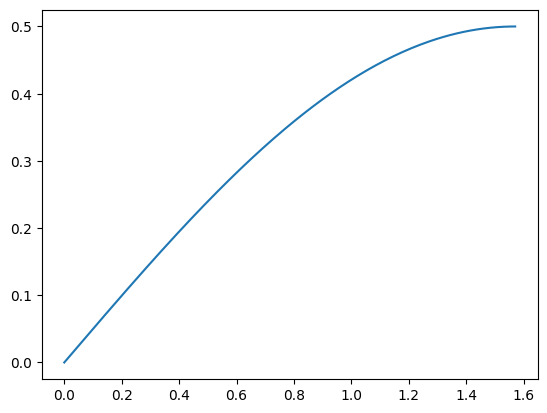

In [16]:
a=0
b=np.pi/2

# Size of grid
N=200
# step size
h=(b-a)/N

# Define right-hand side function
t = sym.var('t')
fsym = sym.sin(t)*0.5
f = sym.lambdify(t, fsym )

# Grid
x=np.linspace(a,b,N+1)

# A matrix
matrix_diff_method = spafdmet.second_derivative_FiniteDiff_sparse_method(N)
A_matrix = matrix_diff_method.CD()

# Right-hand side
F = -h**2*f(x)

# Non-Homogeneous Dirichlet boundary conditions
A_matrix[0,0] = -1*h**2
A_matrix[0,1] = 0
A_matrix[-1,-1] = -1*h**2
A_matrix[-1,-2] = 0

# Compute solution at internal nodes
uh = spsolve(A_matrix,F)
# plot solution
plt.plot(x,uh)
plt.show()


Point 4

Solve the problem with (homogeneous) Neumann conditions:

$ u''(x)=f(x) \quad \in (a,b)$

Fix  $(a,b)=(0,\pi/2)$, $u(x) = sin(x)$.

$u(a)=0, \quad u'(b)=0$

So $f(x)=\sin(x)$.

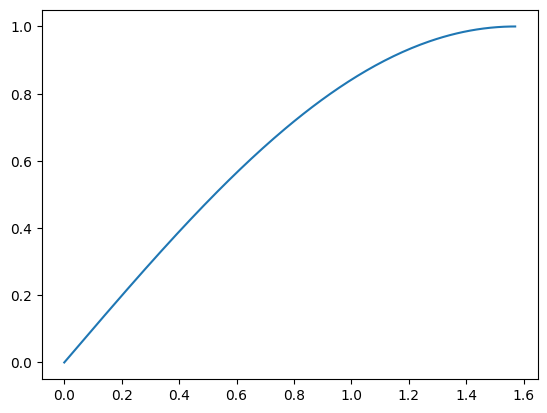

In [17]:
a=0
b=np.pi/2

# Size of grid
N=200
# step size
h=(b-a)/N

# Define right-hand side function
t = sym.var('t')
fsym = sym.sin(t)
f = sym.lambdify(t, fsym )

# Grid
x=np.linspace(a,b,N+1)

# A matrix
matrix_diff_method = spafdmet.second_derivative_FiniteDiff_sparse_method(N)
A_matrix = matrix_diff_method.CD()

# Right-hand side
F = -h**2*f(x)

# Non-Homogeneous Dirichlet boundary conditions
A_matrix[0,0] = -1*h**2
A_matrix[0,1] = 0
A_matrix[-1,-1] = -2
A_matrix[-1,-2] = 2

# Compute solution at internal nodes
uh = spsolve(A_matrix,F)
# plot solution
plt.plot(x,uh)
plt.show()

Point 5

Solve the reaction-advection-diffusion problem (still with central differences):

$-\alpha u''(x)+\beta u'(x)+\gamma u(x)=f(x) \quad \in (a,b)$

$u(a)=u_a, \quad u(b)=u_b$

$f(x) = sin(x)$


For simplicity, take Homogeneous Dirichlet condition and set all coefficients to 1. Also, for simplicity on first and secodn derivative CD method will be used.


In [22]:
# Domain omega with Homogeneous Dirichlet condition
a=0
b=1

# Size of grid
N=200
# step size
h=(b-a)/N

In [23]:
import scipy.sparse as sp
# evaluate function at node n (with gamma coefficient)
list_dg = [np.ones(N+1)]
gamma_matrix = sp.diags(list_dg,[0], format="csr")

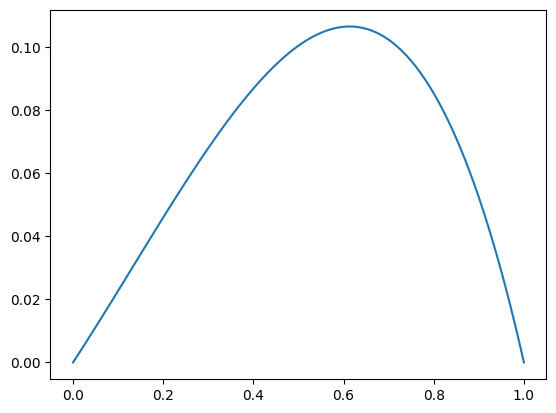

In [28]:

# Define right-hand side function
t = sym.var('t')
fsym = sym.sin(t)
f = sym.lambdify(t, fsym )

# Grid
x=np.linspace(a,b,N+1)

# Second derivative matrix (with alpha coefficient)
matrix_diff_method = spafdmet.second_derivative_FiniteDiff_sparse_method(N)
alpha_matrix = matrix_diff_method.CD()

# First derivative matrix (with beta coefficient)
method_sp = spafdmet.first_order_first_derivative_FiniteDiff_sparse_method(N,(b-a)/N)
beta_matrix = method_sp.CD()

# Compose A_matrix
A_matrix = -0.5*alpha_matrix/(h**2)+0.5*beta_matrix+0.5*gamma_matrix

# Right-hand side (no more h factor on this side since on LHS there is no a common term of h, indeed denominator are h^2, h and 1), now constrain by Dirichlet
F = f(x)


# Homogeneous Dirichlet boundary conditions (the goal of the next 6 steps is to remove from the matrixes the h component, since Homogeneous Dirichlet condition)
# modify system to account for homogeneous Dirichlet boundary conditions
A_matrix[0,0] = 1; A_matrix[0,1] = 0; F[0] = 0
A_matrix[N,N] = 1; A_matrix[N,N-1] = 0; F[N] = 0

# Compute solution at internal nodes
uh = spsolve(A_matrix,F)
# plot solution
plt.plot(x,uh)
plt.show()